In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

plt.style.use('seaborn-whitegrid')

In [2]:
sejm = pd.read_csv('./data/sejm/wystapienia.csv')
slowa = pd.read_csv('./data/sejm/slowka.csv')

slowa_l = slowa.to_dict('records')
slowa_d = {}

# for performance reasons, I've put words in dictionary - selecting them from DataFrame is much slower than using dict
for sl in slowa_l:
    slowa_d[sl['word']] = sl


In [3]:
slowa.head().T

,0,1,2,3,4
word,mamrotać,uparty,żądać,rozrzutny,moralista
category,A,A,A,A,A
nl,8,6,5,9,9
syn,verb,adjective,verb,adjective,noun
f,3.5,7.11,45.95,0.9,1.46
VA,-1,-0.77,-1.08,-1.12,-0.85
AR,2.46,2.54,2.31,2.42,2.04
IM,5.58,5.96,5.88,5.62,4.58
mean_H,1.42,2.65,1.65,1.96,1.81
mean_A,2.96,3.62,3.81,3.85,3.62


In [4]:
labs = {
    "1":"Platforma Obywatelska",
    "10":"Koło poselskie Bezpieczeństwo i Gospodarka",
    "11":"Zjednoczona Prawica",
    "12":"Bialo-Czerwoni",
    "13":"Kukiz'15",
    "14":"Nowoczesna",
    "2":"Prawo i Sprawiedliwosc",
    "3":"Polskie Stronnictwo Ludowe",
    "4":"Sojusz Lewicy Demokratycznej",
    "5":"Ruch Palikota",
    "6":"Solidarna Polska",
    "7":"Niezrzeszeni",
    "8":"Koło Poselskie Inicjatywa Dialogu",
    "9":"Klub Parlamentarny Sprawiedliwa Polska",
    "0":"None"
}

In [5]:
sc = sejm.copy()
sc.set_index('id')
sc['slowa'] = sc.stem.str.split(' ')
sc['klub_nazwa'] = sc.klub_id.apply(lambda x: labs[str(x)])

In [6]:
def get_param_calc_func(param):
    def func(x):
        sre = []
        try:
            for slowo in x.loc['slowa']:
                ary = slowa_d[slowo] if slowo in slowa_d else dict()
                if param in ary:
                    sre.append(ary[param])
                elif param.startswith('impact_') and slowo in slowa_d and param.endswith(ary['category']):
                    sre.append(calc_kolaps_factor(ary, param))
        except Exception as e:
            pass
        return (np.mean(sre)*len(sre))/len(x.loc['slowa']) if len(sre) > 0 else 1

    return func

def calc_kolaps_factor(ar, typ):
    pre = ar['AR'] + ar['IM']
    if typ.endswith('H'):
        return pre * 2 * ar['mean_H']+ 1.5 * np.mean([ar['dist_A'], ar['dist_S'], ar['dist_F'], ar['dist_D'], ar['dist_N']])
    elif typ.endswith('A'):
        return pre * 2 * ar['mean_A'] + 1.5 * np.mean([ar['dist_H'], ar['dist_S'], ar['dist_F'], ar['dist_D'], ar['dist_N']])
    elif typ.endswith('S'):
        return pre * 2 * ar['mean_S'] + 1.5 * np.mean([ar['dist_H'], ar['dist_A'], ar['dist_F'], ar['dist_D'], ar['dist_N']])
    elif typ.endswith('F'):
        return pre * 2 * ar['mean_F'] + 1.5 * np.mean([ar['dist_H'], ar['dist_A'], ar['dist_S'], ar['dist_D'], ar['dist_N']])
    elif typ.endswith('D'):
        return pre * 2 * ar['mean_D'] + 1.5 * np.mean([ar['dist_H'], ar['dist_A'], ar['dist_S'], ar['dist_F'], ar['dist_N']])
    return 1

In [7]:
%%time
par = [
    'impact_H',
    'impact_A',
    'impact_S',
    'impact_F',
    'impact_D',
    'f',
    'VA',
    'AR',
    'IM',
    'mean_H',
    'mean_A',
    'mean_S',
    'mean_F',
    'mean_D',
    'dist_H',
    'dist_A',
    'dist_S',
    'dist_F',
    'dist_D',
    'dist_N',
    'badness'
]
for a in par:
    print("Calculating {}...".format(a))
    sc[a] = sc.apply(get_param_calc_func(a), axis=1)


Calculating impact_H...
Calculating impact_A...
Calculating impact_S...
Calculating impact_F...
Calculating impact_D...
Calculating f...
Calculating VA...
Calculating AR...
Calculating IM...
Calculating mean_H...
Calculating mean_A...
Calculating mean_S...
Calculating mean_F...
Calculating mean_D...
Calculating dist_H...
Calculating dist_A...
Calculating dist_S...
Calculating dist_F...
Calculating dist_D...
Calculating dist_N...
Calculating badness...
CPU times: user 1min 48s, sys: 587 ms, total: 1min 48s
Wall time: 1min 49s


In [8]:
sc['Happiness'] = sc['impact_H']
sc['Anger'] = sc['impact_A']
sc['Sadness'] = sc['impact_S']
sc['Fear'] = sc['impact_F']
sc['Disgust'] = sc['impact_D']
sc['Neutrality Distance'] = sc['dist_N']

In [9]:
sc.set_index(sc.id, inplace=True)

In [10]:
sc.head().T

id,133746,133843,133863,133784,133838
id,133746,133843,133863,133784,133838
stem,bardzo być czyli do dziękować formalny głos gł...,dziękować głos ludowy marek mój pan państwo po...,1 167 256 424 6 być do dziękować głosować i kt...,0 15 5 50 a ale by być chcieć czy dać dla do d...,a ale być dziękować dzienny ja jeżeli na nie N...
ludzie_nazwa,Marek Kuchciński,Marek Kuchciński,Marek Kuchciński,Tomasz Jaskóła,Marek Kuchciński
posel_id,205,205,205,1244,205
ludzie_id,195,195,195,1666,195
data,2017-06-22,2017-06-22,2017-06-22,2017-06-22,2017-06-22
klub_id,0,0,0,0,0
slowa,"[bardzo, być, czyli, do, dziękować, formalny, ...","[dziękować, głos, ludowy, marek, mój, pan, pań...","[1, 167, 256, 424, 6, być, do, dziękować, głos...","[0, 15, 5, 50, a, ale, by, być, chcieć, czy, d...","[a, ale, być, dziękować, dzienny, ja, jeżeli, ..."
klub_nazwa,None,None,None,None,None
impact_H,3.06518,5.6195,3.3717,1.36691,2.80975


In [11]:
def plot_emotion(emotion):
    sc \
        .groupby('klub_nazwa') \
        .agg(np.mean) \
        .sort_values(by=emotion)[emotion] \
        .T \
        .plot(kind='bar', title=emotion)

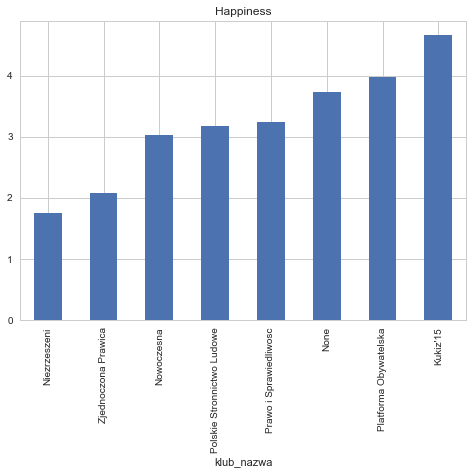

In [12]:
plot_emotion('Happiness')

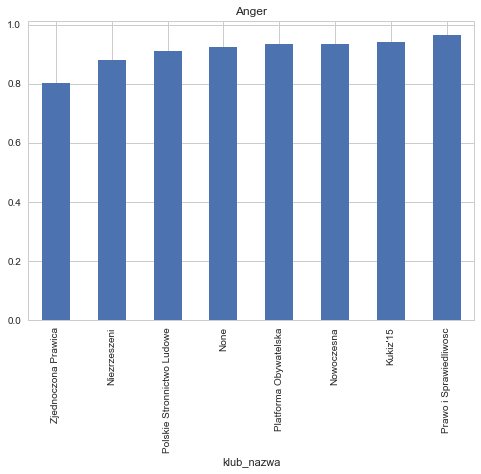

In [13]:
plot_emotion('Anger')

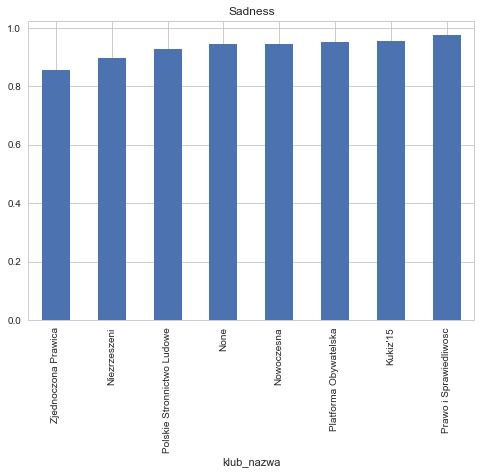

In [14]:
plot_emotion('Sadness')

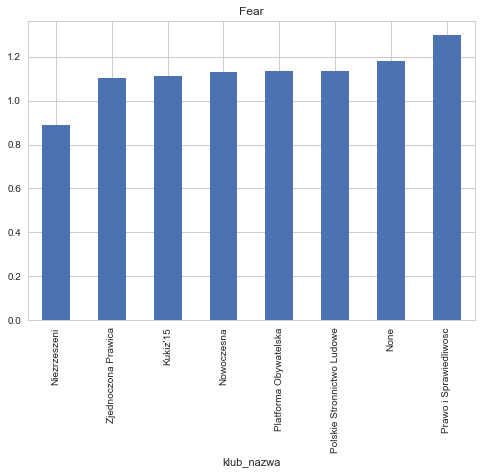

In [15]:
plot_emotion('Fear')

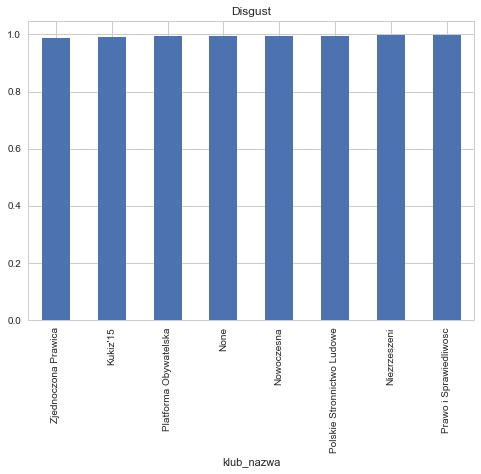

In [16]:
plot_emotion('Disgust')

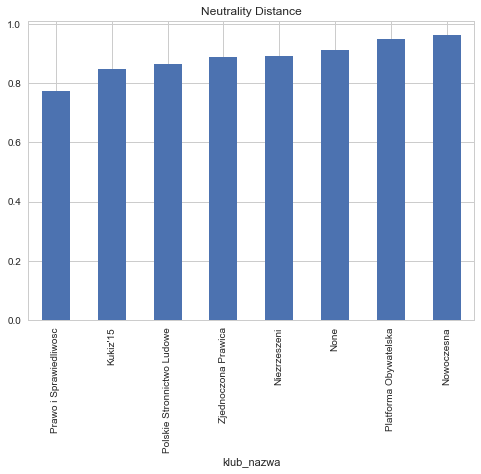

In [17]:
plot_emotion('Neutrality Distance')

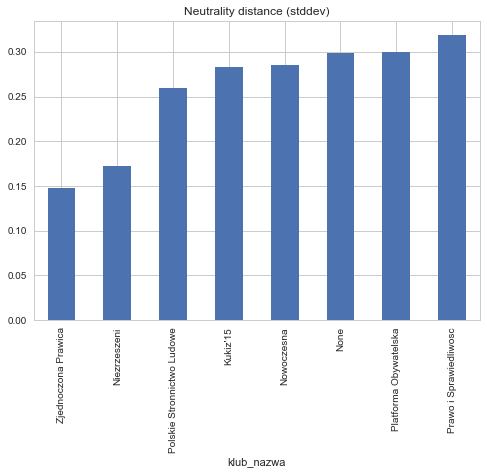

In [18]:
sc.groupby('klub_nazwa') \
    .agg(np.std) \
    .sort_values(by='dist_N')['dist_N'] \
    .plot(kind='bar', title='Neutrality distance (stddev)')

In [19]:
sc['lk'] = sc['ludzie_nazwa'] + ' (' + sc['klub_nazwa'] + ')'

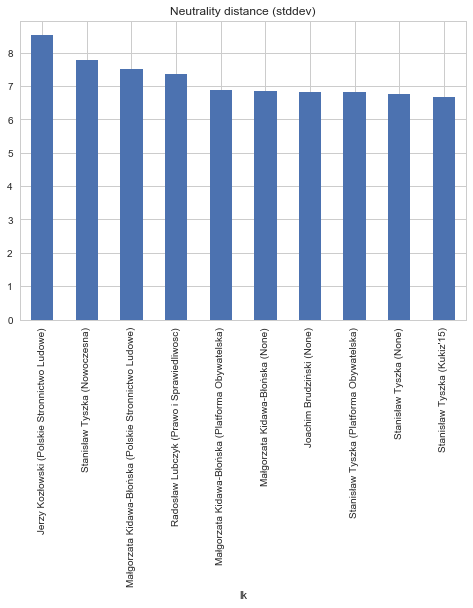

In [20]:
sc.groupby('lk') \
    .agg(np.mean) \
    .sort_values(by='Happiness', ascending=False) \
    .head(10)['Happiness'] \
    .plot(kind='bar', title='Neutrality distance (stddev)')

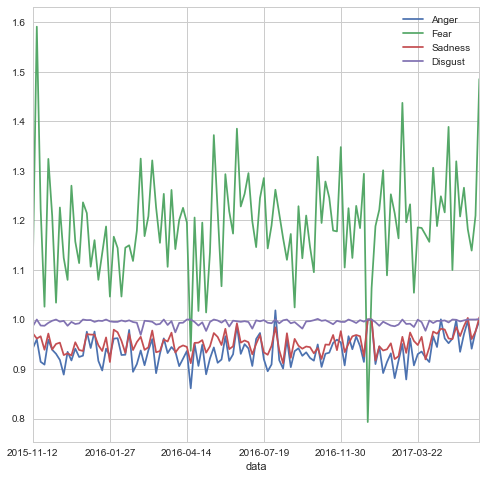

In [21]:
sc.groupby(['data']) \
    .agg(np.mean)[['Anger', 'Fear', 'Sadness', 'Disgust']] \
    .plot(figsize=(8,8))